# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import tensorflow as tf
import random

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from keras.models import Sequential
from keras.layers import Dense

# Pendahuluan

In [ ]:
# Import dataset

from google.colab import files

uploaded = files.upload()

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

KeyboardInterrupt: 

Untuk membuat model, kita akan bekerja dengan dataset `df_train` terlebih dahulu.



## Bukti Dataset Tidak Berdistribusi Normal

In [ ]:
# Lakukan uji Kolmogorov-Smirnov untuk setiap kolom

hasil = []

for column in df_train.columns:
    data = df_train[column]
    ks_stat, ks_p_value = stats.kstest(data, 'norm', args=(data.mean(), data.std()))

    # Interpretasi hasil
    alpha = 0.05
    if ks_p_value < alpha:
        distribusi = "Tidak Normal"
    else:
        distribusi = "Normal"

    # Tambahkan hasil ke list
    hasil.append([column, ks_stat, ks_p_value, distribusi])

# Buat DataFrame dari hasil
hasil_df = pd.DataFrame(hasil, columns=['Kolom', 'KS Statistic', 'p-value', 'Distribusi'])

# Tampilkan hasil dalam bentuk tabel
print("Hasil Uji Kolmogorov-Smirnov")
print(hasil_df)

Hasil Uji Kolmogorov-Smirnov
                     Kolom  KS Statistic        p-value    Distribusi
0                       id      0.057267   1.099656e-18  Tidak Normal
1        Alkalinity, total      0.092842   1.851692e-48  Tidak Normal
2                  Calcium      0.473978   0.000000e+00  Tidak Normal
3                 Chloride      0.285584   0.000000e+00  Tidak Normal
4                 Fluoride      0.286719   0.000000e+00  Tidak Normal
5                Magnesium      0.471341   0.000000e+00  Tidak Normal
6             Nitrate as N      0.244170   0.000000e+00  Tidak Normal
7                   Sodium      0.456796   0.000000e+00  Tidak Normal
8    Specific Conductivity      0.189636  5.152479e-202  Tidak Normal
9                  Sulfate      0.255521   0.000000e+00  Tidak Normal
10  Total Dissolved Solids      0.155957  2.050973e-136  Tidak Normal
11                Hardness      0.117982   4.453993e-78  Tidak Normal


Didapat bahwa setiap fitur pada dataset `df_test` tidak berasal dari distribusi normal.

## Bukti Hubungannya Non Linear

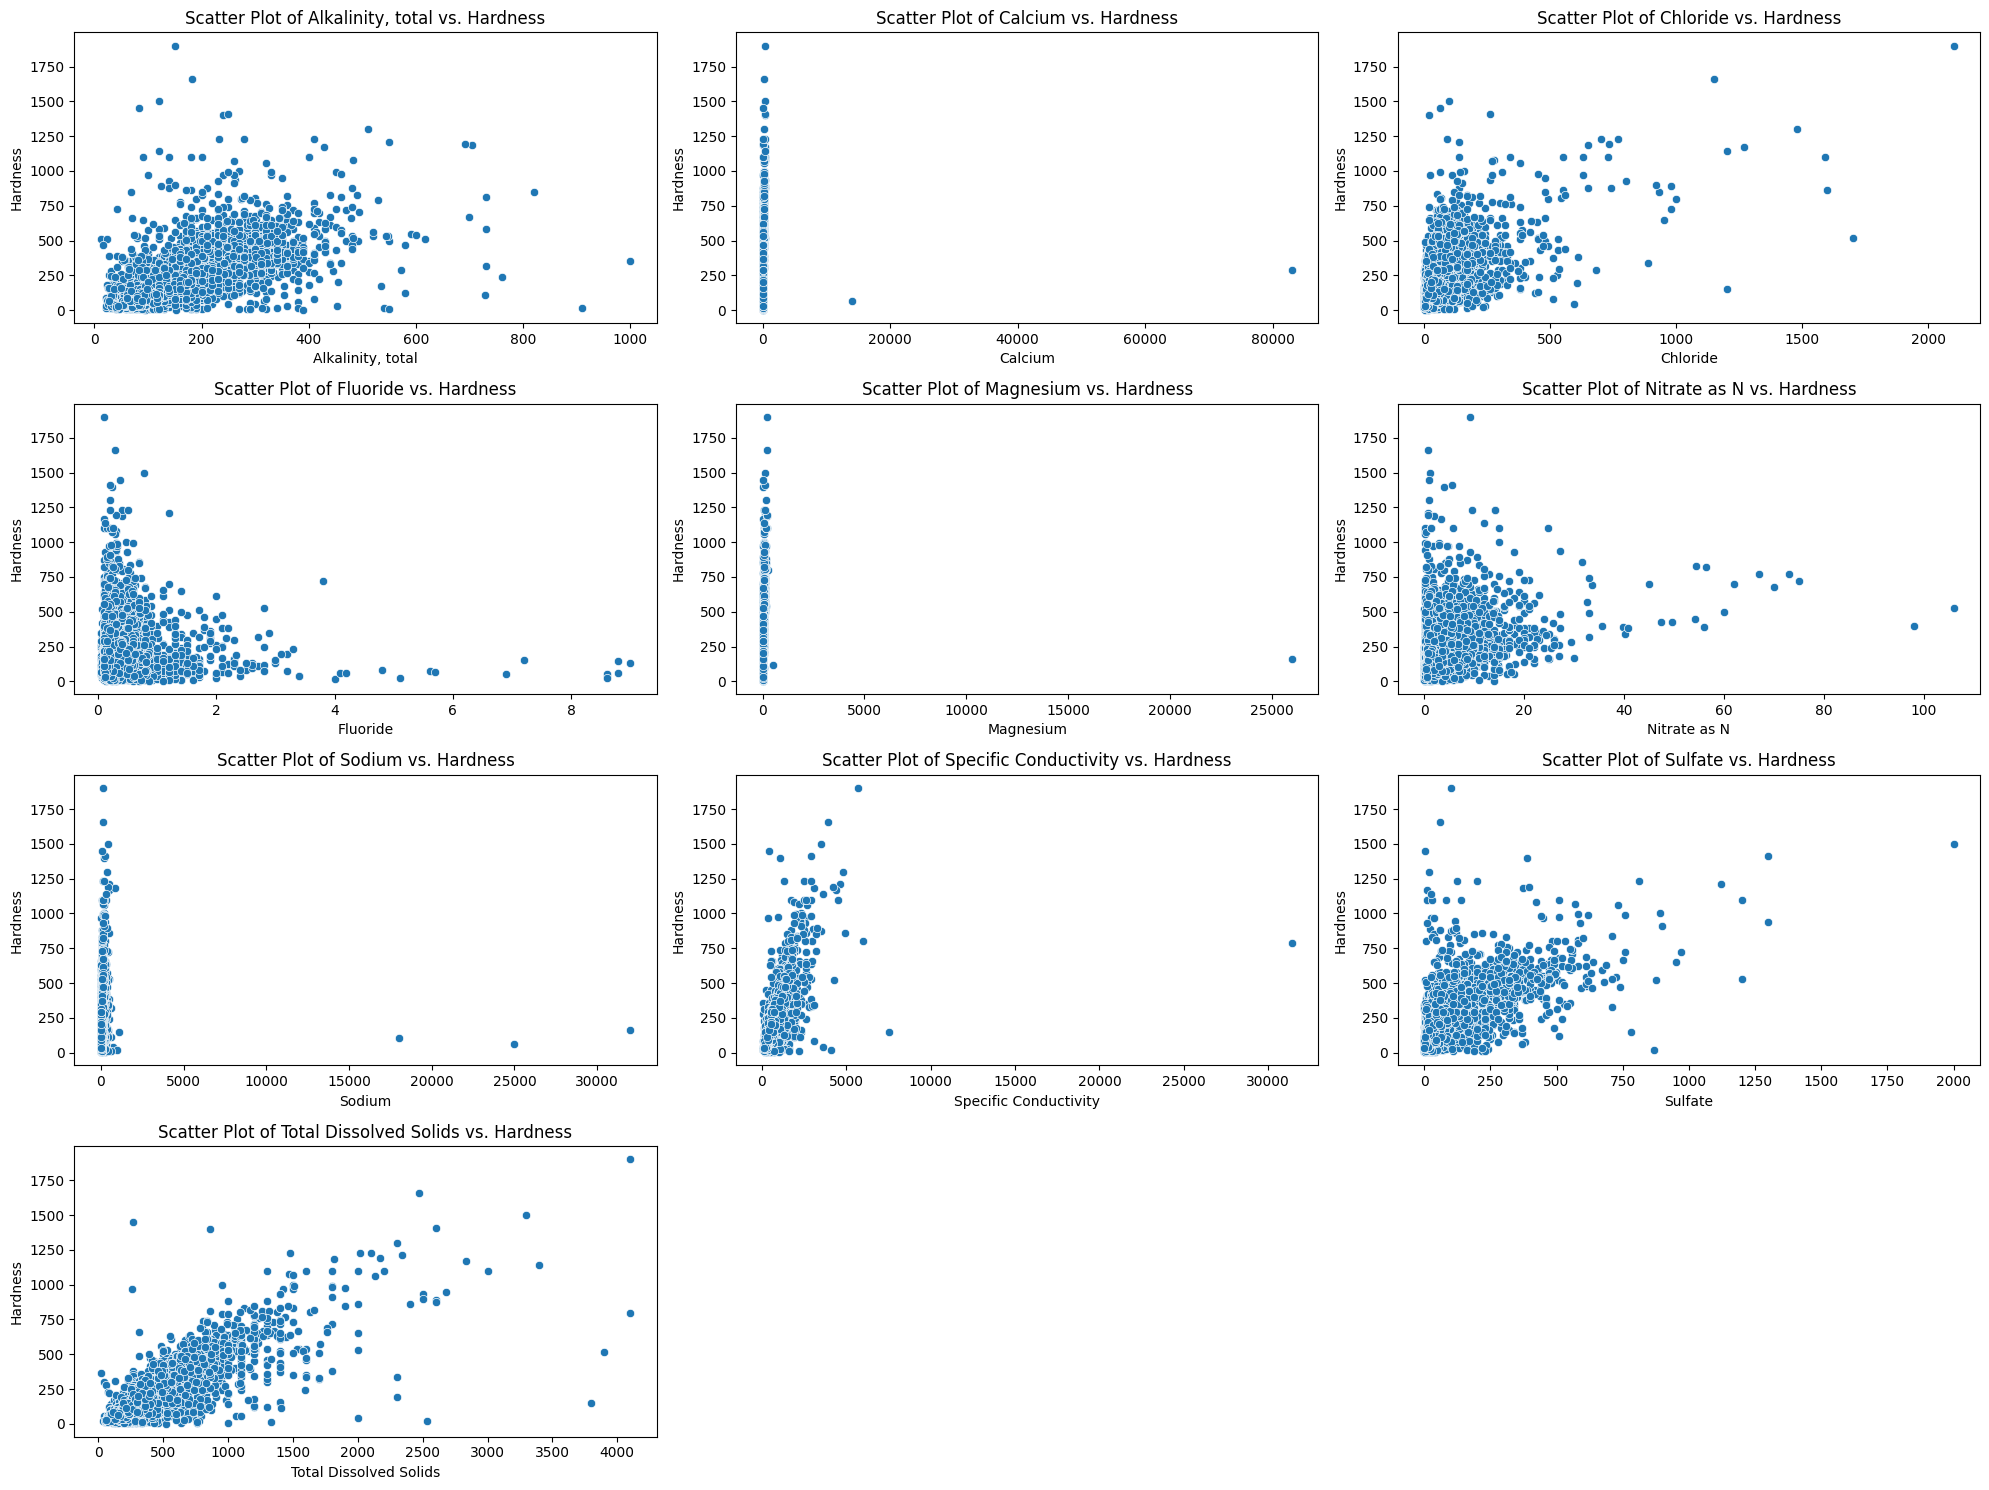

In [ ]:
# List fitur yang akan di-plot
features = ['Alkalinity, total','Calcium', 'Chloride', 'Fluoride', 'Magnesium',
            'Nitrate as N', 'Sodium', 'Specific Conductivity', 'Sulfate', 'Total Dissolved Solids']

# Membuat scatter plot untuk setiap fitur terhadap Hardness
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features, 1):
    plt.subplot(4, 3, i)  # 4 baris, 3 kolom grid
    sns.scatterplot(x=feature, y='Hardness', data=df_train)
    plt.title(f'Scatter Plot of {feature} vs. Hardness')

plt.tight_layout()
plt.show()

                          MSE Linear  MSE Polynomial  Model Type
Feature                                                         
Alkalinity, total       15394.769391    14886.247390  Non-linear
Calcium                 26019.129172    24729.032951  Non-linear
Chloride                18393.848225    17406.915967  Non-linear
Fluoride                26055.503229    25922.598999  Non-linear
Magnesium               26004.540388     9984.079304  Non-linear
Nitrate as N            23910.815482    23586.035969  Non-linear
Sodium                  26038.710872    25249.182386  Non-linear
Specific Conductivity   15540.637513     9172.735381  Non-linear
Sulfate                 14759.078923    14119.741318  Non-linear
Total Dissolved Solids   8740.398091     7806.302729  Non-linear


<ipython-input-5-fc5de627e49b>:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_grid = np.arange(min(X), max(X), 0.1).reshape(-1, 1)
<ipython-input-5-fc5de627e49b>:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_grid = np.arange(min(X), max(X), 0.1).reshape(-1, 1)
<ipython-input-5-fc5de627e49b>:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_grid = np.arange(min(X), max(X), 0.1).reshape(-1, 1)
<ipython-input-5-fc5de627e49b>:67: DeprecationWarning: Conver

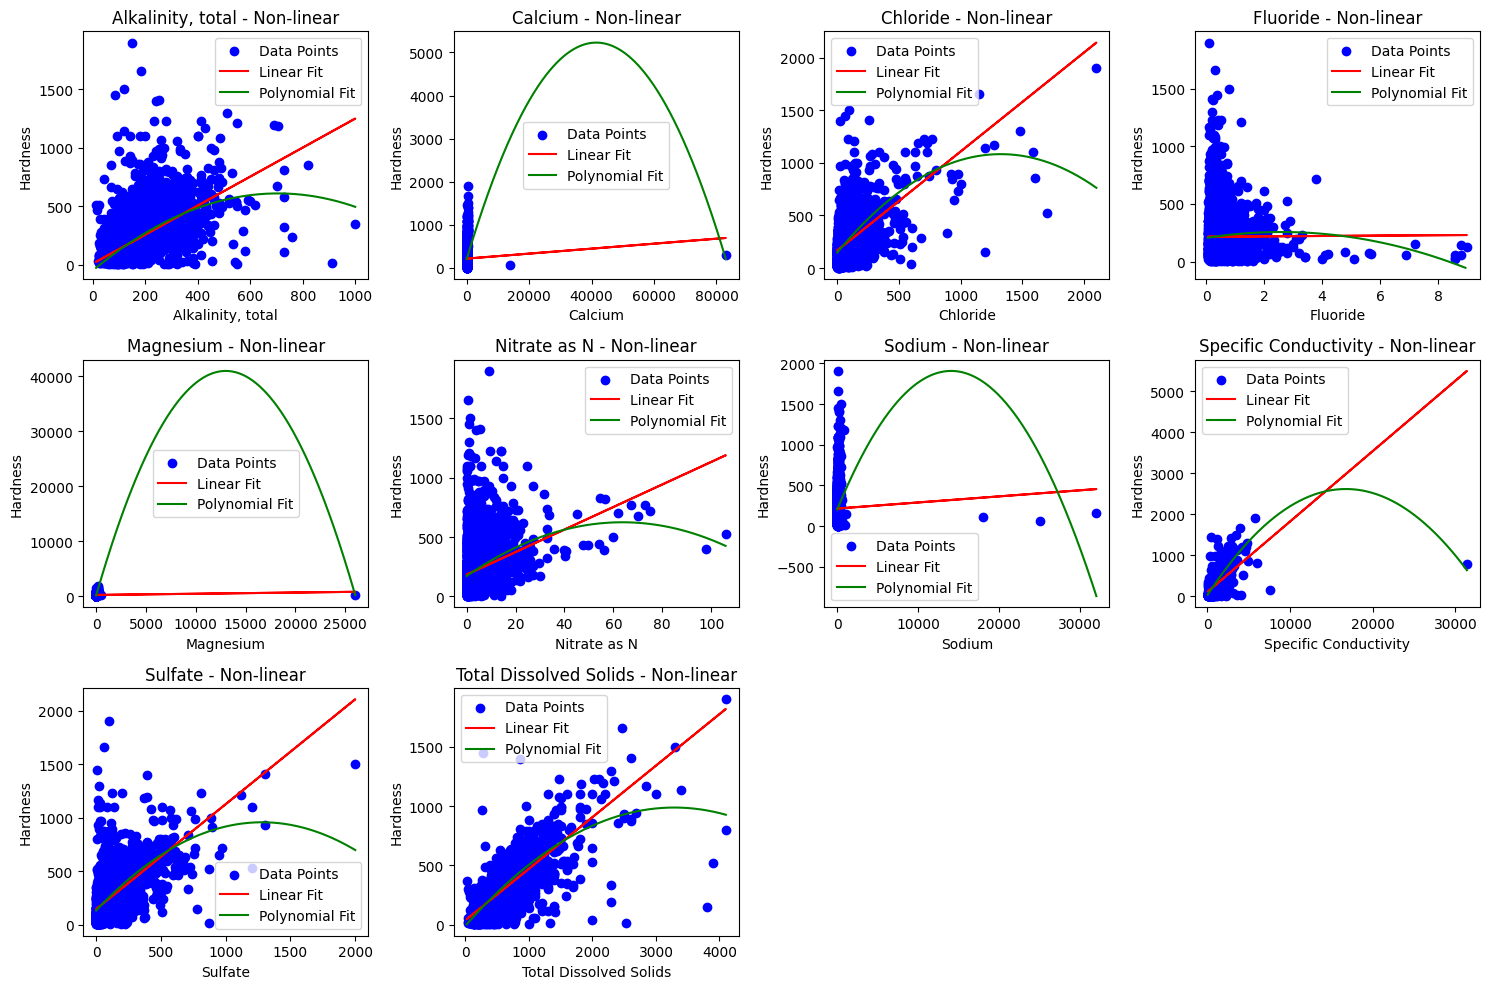

In [ ]:
# Cek dengan Analisis Polynomial Regression.

# List fitur yang akan di-plot
features = ['Alkalinity, total','Calcium', 'Chloride', 'Fluoride', 'Magnesium',
            'Nitrate as N', 'Sodium', 'Specific Conductivity', 'Sulfate', 'Total Dissolved Solids']

# Inisialisasi list untuk menyimpan hasil
results = []

# Loop untuk setiap fitur
for feature in features:
    if feature != 'Hardness':  # Hardness adalah target, tidak perlu dianalisis
        X = df_train[feature].values.reshape(-1, 1)
        y = df_train['Hardness'].values  # Menggunakan 'Hardness' sebagai target

        # Model Linear
        linear_regressor = LinearRegression()
        linear_regressor.fit(X, y)
        y_pred_linear = linear_regressor.predict(X)
        mse_linear = mean_squared_error(y, y_pred_linear)

        # Model Polynomial (degree 2)
        poly = PolynomialFeatures(degree=2)
        X_poly = poly.fit_transform(X)
        poly_regressor = LinearRegression()
        poly_regressor.fit(X_poly, y)
        y_pred_poly = poly_regressor.predict(X_poly)
        mse_poly = mean_squared_error(y, y_pred_poly)

        # Evaluasi apakah model tergolong non-linear (berdasarkan perbandingan MSE)
        if mse_poly < mse_linear:
            model_type = 'Non-linear'
        else:
            model_type = 'Linear'

        # Menyimpan hasil ke dalam list
        results.append([feature, mse_linear, mse_poly, model_type])

# Membuat DataFrame untuk hasil
results_df = pd.DataFrame(results, columns=['Feature', 'MSE Linear', 'MSE Polynomial', 'Model Type'])
results_df.set_index('Feature', inplace=True)
print(results_df)

# Plot hasil untuk setiap fitur
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    if feature != 'Hardness':
        X = df_train[feature].values.reshape(-1, 1)
        y = df_train['Hardness'].values

        # Model Linear
        linear_regressor = LinearRegression()
        linear_regressor.fit(X, y)
        y_pred_linear = linear_regressor.predict(X)

        # Model Polynomial (degree 2)
        poly = PolynomialFeatures(degree=2)
        X_poly = poly.fit_transform(X)
        poly_regressor = LinearRegression()
        poly_regressor.fit(X_poly, y)
        y_pred_poly = poly_regressor.predict(X_poly)

        # Plot data dan model
        plt.subplot(3, 4, i + 1)
        plt.scatter(X, y, color='blue', label='Data Points')
        plt.plot(X, y_pred_linear, color='red', label='Linear Fit')
        X_grid = np.arange(min(X), max(X), 0.1).reshape(-1, 1)
        plt.plot(X_grid, poly_regressor.predict(poly.fit_transform(X_grid)), color='green', label='Polynomial Fit')
        plt.title(f'{feature} - {results_df.loc[feature, "Model Type"]}')
        plt.xlabel(feature)
        plt.ylabel('Hardness')
        plt.legend()

plt.tight_layout()
plt.show()

## Jawaban No 3

In [ ]:
# Jawaban nomor 3a

# Menghitung persentil ke-75 dari fitur Sodium
persentil_75 = df_train['Sodium'].quantile(0.75)

# Menghitung rata-rata nilai fitur Alkalinity
mean_alkalinity = df_train['Alkalinity, total'].mean()

# Memfilter dataset berdasarkan nilai Sodium di atas persentil ke-75 dan nilai Alkalinity di atas rata-rata
hasil_df = df_train[(df_train['Sodium'] > persentil_75) & (df_train['Alkalinity, total'] > mean_alkalinity)]

# Menghitung rata-rata variabel target untuk kondisi tersebut
mean_hardness = hasil_df['Hardness'].mean()

print("Hardness rata-rata dari sumber air yang memiliki kadar sodium di atas persentil 75 dan memiliki tingkat kebasaan (Alkalinity) di atas rata-rata:", mean_hardness)

Hardness rata-rata dari sumber air yang memiliki kadar sodium di atas persentil 75 dan memiliki tingkat kebasaan (Alkalinity) di atas rata-rata: 383.0833134765625


In [ ]:
# Jawaban nomor 3b

# Menghitung kuartil
Q1 = df_train['Alkalinity, total'].quantile(0.25)
Q3 = df_train['Alkalinity, total'].quantile(0.75)
IQR = Q3 - Q1

# Menentukan batas bawah dan atas
batas_bawah = Q1 - 1.5 * IQR
batas_atas = Q3 + 1.5 * IQR

# Menandai outlier
outliers = df_train[(df_train['Alkalinity, total'] < batas_bawah) | (df_train['Alkalinity, total'] > batas_atas)]
print("Outliers:\n", outliers)

Outliers:
         id  Alkalinity, total  Calcium  Chloride  Fluoride  Magnesium  \
34      34              400.0    31.00     160.0      0.40      43.00   
36      36              360.0    16.00     170.0      1.70      14.00   
39      39              617.0    87.30     179.0      1.20      71.20   
48      48              360.0   153.00     146.0      0.10      90.00   
54      54              370.0    69.89      82.8      0.21      32.51   
...    ...                ...      ...       ...       ...        ...   
6193  6193              410.0   110.00     130.0      0.61      72.00   
6204  6204              390.0    81.00      66.0      0.27      53.00   
6206  6206              390.0    52.00      98.0      0.29      35.00   
6323  6323              461.0   126.00     119.0      0.20      58.00   
6363  6363              450.0   200.00     170.0      0.48      57.00   

      Nitrate as N  Sodium  Specific Conductivity  Sulfate  \
34            1.30   290.0                 1290.0 

In [ ]:
import numpy as np

def detect_outliers_iqr(data, threshold=1.5):
    # Hitung kuartil
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)

    # Hitung IQR
    iqr = q3 - q1

    # Hitung batas atas dan batas bawah
    lower_bound = q1 - (threshold * iqr)
    upper_bound = q3 + (threshold * iqr)

    # Mendeteksi outlier
    outliers_indices = np.where((data < lower_bound) | (data > upper_bound))[0]
    outliers_count = len(outliers_indices)

    return outliers_indices, outliers_count

# Contoh penggunaan program
if __name__ == "__main__":
    # Mengambil data dari kolom 'Alkalinity, total'
    data = df_train['Alkalinity, total'].values

    # Mendeteksi outlier berdasarkan IQR
    outliers_indices, outliers_count = detect_outliers_iqr(data)

    # Menampilkan outlier
    if outliers_count > 0:
        print("Total outlier yang ditemukan:", outliers_count)
        print("")
        print("Outlier ditemukan pada indeks:", outliers_indices)
        print("")
        print("Nilai outlier:", data[outliers_indices])
    else:
        print("Tidak ada outlier yang ditemukan.")

    # Menandai outlier dalam DataFrame
    outliers = df_train.iloc[outliers_indices]
    print("Outliers:\n", outliers)

Total outlier yang ditemukan: 174

Outlier ditemukan pada indeks: [  34   36   39   48   54   85  116  117  200  208  217  259  283  335
  368  378  381  401  480  481  535  558  646  685  699  709  771  813
  823  862  863  865  943  952 1030 1084 1293 1298 1387 1466 1475 1495
 1596 1651 1660 1711 1716 1753 1803 1888 1901 1981 2050 2104 2127 2138
 2171 2231 2291 2304 2311 2365 2392 2394 2415 2447 2517 2519 2534 2560
 2593 2601 2611 2725 2734 2787 2790 2819 2842 2913 2963 2984 3035 3084
 3085 3104 3120 3148 3162 3166 3216 3300 3314 3438 3445 3452 3465 3500
 3564 3566 3579 3609 3616 3663 3687 3710 3716 3914 3970 4022 4082 4090
 4095 4113 4122 4128 4280 4294 4308 4313 4330 4341 4343 4353 4451 4459
 4475 4477 4628 4672 4734 4812 4832 4852 4894 4983 4985 5016 5138 5276
 5282 5290 5311 5329 5346 5385 5389 5393 5415 5472 5565 5577 5623 5624
 5693 5700 5721 5795 5823 5855 5885 5899 5991 5997 6006 6039 6140 6160
 6182 6193 6204 6206 6323 6363]

Nilai outlier: [ 400.  360.  617.  360.  370.  59

## Jawaban No 4

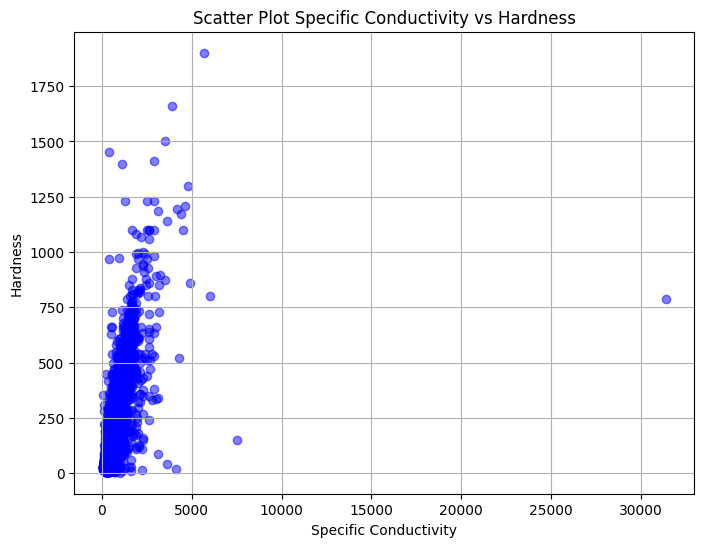

In [ ]:
# Membuat scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_train['Specific Conductivity'], df_train['Hardness'], color='blue', alpha=0.5)
plt.title('Scatter Plot Specific Conductivity vs Hardness')
plt.xlabel('Specific Conductivity')
plt.ylabel('Hardness')
plt.grid(True)
plt.show()

In [ ]:
# List semua fitur yang akan diuji dengan Spearman
features = ['Specific Conductivity']

# Loop untuk melakukan uji Spearman untuk setiap fitur terhadap variabel target 'Hardness'
for feature in features:
    corr, p_value = stats.spearmanr(df_train[feature], df_train['Hardness'])
    print(f"Feature: {feature}")
    print(f"Korelasi Spearman: {corr:.4f}, p-value: {p_value:.4f}")

    alpha = 0.05
    if p_value < alpha:
        print('Kesimpulan: Terdapat hubungan yang signifikan antara dua variabel (tolak H0)')
    else:
        print('Kesimpulan: Tidak cukup bukti untuk menolak H0: Tidak ada hubungan yang signifikan')

    print()

Feature: Specific Conductivity
Korelasi Spearman: 0.8385, p-value: 0.0000
Kesimpulan: Terdapat hubungan yang signifikan antara dua variabel (tolak H0)



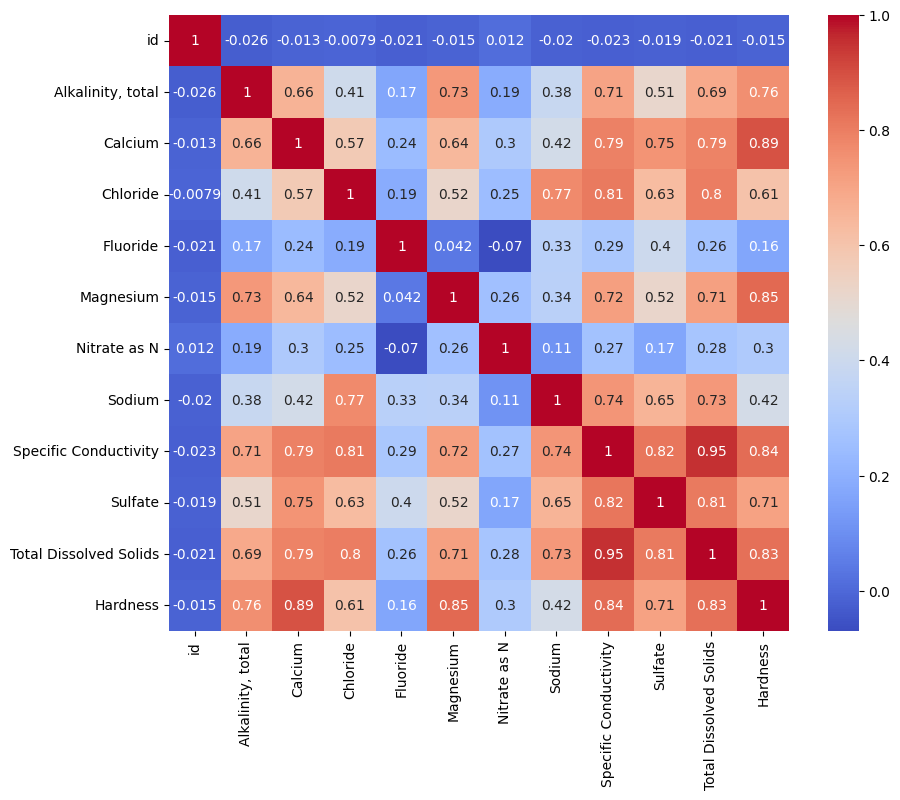

In [ ]:
# Matriks Korelasi dengan Metode Spearman
correlation_matrix = df_train.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

## Jawaban No 5

In [ ]:
import pandas as pd
from scipy.stats import spearmanr

def compute_correlation(data, feature1, feature2):
    corr, _ = spearmanr(data[feature1], data[feature2])
    return corr

def sort_correlations(data, feature1, features):
    correlations = []
    for feature2 in features:
        corr = compute_correlation(data, feature1, feature2)
        correlations.append((feature2, corr))

    df_corr = pd.DataFrame(correlations, columns=['Feature', 'Spearman Correlation'])
    df_corr_sorted = df_corr.sort_values(by='Spearman Correlation', ascending=False)

    return df_corr_sorted

if __name__ == "__main__":

    # Definisikan fitur yang ingin dianalisis korelasinya
    feature1 = 'Hardness'
    features_to_compare = ['Calcium', 'Chloride', 'Fluoride', 'Magnesium', 'Nitrate as N', 'Sodium', 'Sulfate']

    # Mengurutkan korelasi
    sorted_correlations = sort_correlations(df_train, feature1, features_to_compare)

    # Menampilkan hasil urutan korelasi
    print(f"Korelasi {feature1} dengan fitur lainnya (Spearman):")
    print(sorted_correlations)

    print("")

    # Menampilkan hasil urutan korelasi dari yang paling kuat
    print(f"Korelasi {feature1} dengan fitur lainnya (Spearman), diurutkan dari yang paling kuat:")
    for index, row in sorted_correlations.iterrows():
        correlation_strength = ""
        correlation_value = row['Spearman Correlation']
        if correlation_value > 0.90:
            correlation_strength = "Sangat Kuat"
        elif correlation_value >= 0.70:
            correlation_strength = "Kuat"
        elif correlation_value >= 0.50:
            correlation_strength = "Moderat"
        elif correlation_value >= 0.26:
            correlation_strength = "Lemah"
        else:
            correlation_strength = "Sangat Lemah"

        print(f"{row['Feature']}: {correlation_strength} (Spearman Correlation = {correlation_value:.4f})")


Korelasi Hardness dengan fitur lainnya (Spearman):
        Feature  Spearman Correlation
0       Calcium              0.892554
3     Magnesium              0.847766
6       Sulfate              0.711235
1      Chloride              0.606693
5        Sodium              0.424676
4  Nitrate as N              0.304983
2      Fluoride              0.164161

Korelasi Hardness dengan fitur lainnya (Spearman), diurutkan dari yang paling kuat:
Calcium: Kuat (Spearman Correlation = 0.8926)
Magnesium: Kuat (Spearman Correlation = 0.8478)
Sulfate: Kuat (Spearman Correlation = 0.7112)
Chloride: Moderat (Spearman Correlation = 0.6067)
Sodium: Lemah (Spearman Correlation = 0.4247)
Nitrate as N: Lemah (Spearman Correlation = 0.3050)
Fluoride: Sangat Lemah (Spearman Correlation = 0.1642)


## Data `df_train` untuk data latih

In [ ]:
# Melihat 5 baris pertama dari dataset

df_train.head()

,id,"Alkalinity, total",Calcium,Chloride,Fluoride,Magnesium,Nitrate as N,Sodium,Specific Conductivity,Sulfate,Total Dissolved Solids,Hardness
0,0,120.0,24.0,6.9,0.314,7.1,0.498,48.0,510.0,23.2,240.0,90.4
1,1,140.0,41.0,11.0,0.150,6.5,0.950,19.0,300.0,8.5,190.0,130.0
2,2,160.0,51.0,9.0,0.450,9.1,2.500,12.0,370.0,25.0,230.0,160.0
3,3,46.0,13.0,2.9,0.120,2.7,0.430,6.4,110.0,5.0,97.0,41.0
4,4,240.0,147.0,70.0,0.600,48.0,6.800,93.0,1410.0,418.0,950.0,586.0


In [ ]:
# Statistik deskriptif

df_train.describe()

,id,"Alkalinity, total",Calcium,Chloride,Fluoride,Magnesium,Nitrate as N,Sodium,Specific Conductivity,Sulfate,Total Dissolved Solids,Hardness
count,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000
mean,3199.500000,167.151047,69.350432,53.213620,0.333625,23.446335,3.382707,62.437731,637.631953,71.645934,409.570669,216.148203
std,1847.665193,83.157803,1052.136452,92.934505,0.452473,325.389503,4.878279,556.891904,597.297274,108.414049,302.958442,161.431526
min,0.000000,12.000000,0.610000,0.580000,0.049000,0.051000,0.002300,1.300000,40.000000,0.140000,19.580000,2.500000
25%,1599.750000,110.000000,25.000000,11.000000,0.140000,7.300000,0.850000,21.000000,340.000000,13.000000,220.000000,101.000000
50%,3199.500000,153.500000,45.000000,28.000000,0.210000,14.000000,2.000000,35.000000,520.000000,33.000000,320.000000,180.000000
75%,4799.250000,209.000000,72.000000,62.000000,0.382250,25.000000,4.300000,60.000000,800.000000,85.000000,500.000000,281.000000
max,6399.000000,1000.000000,83000.000000,2100.000000,9.000000,26000.000000,106.000000,32000.000000,31400.000000,2000.000000,4100.000000,1901.000000


*((berikan penjelasan mengenai statistik deskriptif))*

In [ ]:
# Ringkasan singkat mengenai DataFrame

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      6400 non-null   int64  
 1   Alkalinity, total       6400 non-null   float64
 2   Calcium                 6400 non-null   float64
 3   Chloride                6400 non-null   float64
 4   Fluoride                6400 non-null   float64
 5   Magnesium               6400 non-null   float64
 6   Nitrate as N            6400 non-null   float64
 7   Sodium                  6400 non-null   float64
 8   Specific Conductivity   6400 non-null   float64
 9   Sulfate                 6400 non-null   float64
 10  Total Dissolved Solids  6400 non-null   float64
 11  Hardness                6400 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 600.1 KB


Dataset `df_train` memiliki 12 fitur, terdapat 11 fitur dengan tipe float64 dan 1 fitur dengan tipe int64. Semua fitur adalah numerik.

In [ ]:
# Melihat apakah ada nilai kosong (missing value)

print(df_train.isnull().sum())

id                        0
Alkalinity, total         0
Calcium                   0
Chloride                  0
Fluoride                  0
Magnesium                 0
Nitrate as N              0
Sodium                    0
Specific Conductivity     0
Sulfate                   0
Total Dissolved Solids    0
Hardness                  0
dtype: int64


Tidak ada *missing value* pada `df_train`.

In [ ]:
# Memeriksa data duplikat
duplicates = df_train.duplicated()
print("Duplikat dalam DataFrame:")
print(duplicates)

# Menampilkan baris yang duplikat
print("Baris duplikat dalam DataFrame:")
print(df_train[duplicates])

Duplikat dalam DataFrame:
0       False
1       False
2       False
3       False
4       False
        ...  
6395    False
6396    False
6397    False
6398    False
6399    False
Length: 6400, dtype: bool
Baris duplikat dalam DataFrame:
Empty DataFrame
Columns: [id, Alkalinity, total, Calcium, Chloride, Fluoride, Magnesium, Nitrate as N, Sodium, Specific Conductivity, Sulfate, Total Dissolved Solids, Hardness]
Index: []


Tidak ada data duplikat.

## Data `df_test`: data tes yang harus diprediksi



In [ ]:
# Melihat 5 baris pertama dari dataset

df_train.head()

,id,"Alkalinity, total",Calcium,Chloride,Fluoride,Magnesium,Nitrate as N,Sodium,Specific Conductivity,Sulfate,Total Dissolved Solids,Hardness
0,0,120.0,24.0,6.9,0.314,7.1,0.498,48.0,510.0,23.2,240.0,90.4
1,1,140.0,41.0,11.0,0.150,6.5,0.950,19.0,300.0,8.5,190.0,130.0
2,2,160.0,51.0,9.0,0.450,9.1,2.500,12.0,370.0,25.0,230.0,160.0
3,3,46.0,13.0,2.9,0.120,2.7,0.430,6.4,110.0,5.0,97.0,41.0
4,4,240.0,147.0,70.0,0.600,48.0,6.800,93.0,1410.0,418.0,950.0,586.0


In [ ]:
# Statistik deskriptif

df_test.describe()

,id,"Alkalinity, total",Calcium,Chloride,Fluoride,Magnesium,Nitrate as N,Sodium,Specific Conductivity,Sulfate,Total Dissolved Solids
count,1601.000000,1601.000000,1601.000000,1601.000000,1601.000000,1601.000000,1601.000000,1601.000000,1601.000000,1601.000000,1601.000000
mean,7200.000000,168.832299,55.668958,51.481462,0.349397,62.757297,3.423275,77.886431,659.276702,75.164221,409.850094
std,462.313206,82.953613,41.717342,77.520902,0.551632,1724.080876,4.968633,780.983717,620.275872,121.649147,271.134286
min,6400.000000,9.400000,0.260000,0.460000,0.000000,0.064000,0.004740,2.200000,66.000000,0.390000,29.000000
25%,6800.000000,110.000000,26.000000,12.000000,0.140000,7.800000,0.770000,21.000000,351.000000,13.100000,230.000000
50%,7200.000000,160.000000,46.200000,31.000000,0.210000,15.000000,2.000000,35.000000,530.000000,34.000000,330.000000
75%,7600.000000,210.000000,74.000000,63.000000,0.380000,25.000000,4.300000,61.000000,815.000000,94.600000,510.000000
max,8000.000000,700.000000,460.000000,1300.000000,9.900000,69000.000000,58.200000,27400.000000,17400.000000,2100.000000,2300.000000


In [ ]:
# Ringkasan singkat mengenai DataFrame

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1601 entries, 0 to 1600
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1601 non-null   int64  
 1   Alkalinity, total       1601 non-null   float64
 2   Calcium                 1601 non-null   float64
 3   Chloride                1601 non-null   float64
 4   Fluoride                1601 non-null   float64
 5   Magnesium               1601 non-null   float64
 6   Nitrate as N            1601 non-null   float64
 7   Sodium                  1601 non-null   float64
 8   Specific Conductivity   1601 non-null   float64
 9   Sulfate                 1601 non-null   float64
 10  Total Dissolved Solids  1601 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 137.7 KB


Hanya ada 11 fitur, fitur `Hardness` tidak ada karena merupakan fitur target.

In [ ]:
# Melihat apakah ada nilai kosong (missing value)

print(df_test.isnull().sum())

id                        0
Alkalinity, total         0
Calcium                   0
Chloride                  0
Fluoride                  0
Magnesium                 0
Nitrate as N              0
Sodium                    0
Specific Conductivity     0
Sulfate                   0
Total Dissolved Solids    0
dtype: int64


Tidak ada *missing value* pada `df_train`.

# Exploratory Data Analysis (EDA)

<Figure size 1500x1000 with 0 Axes>

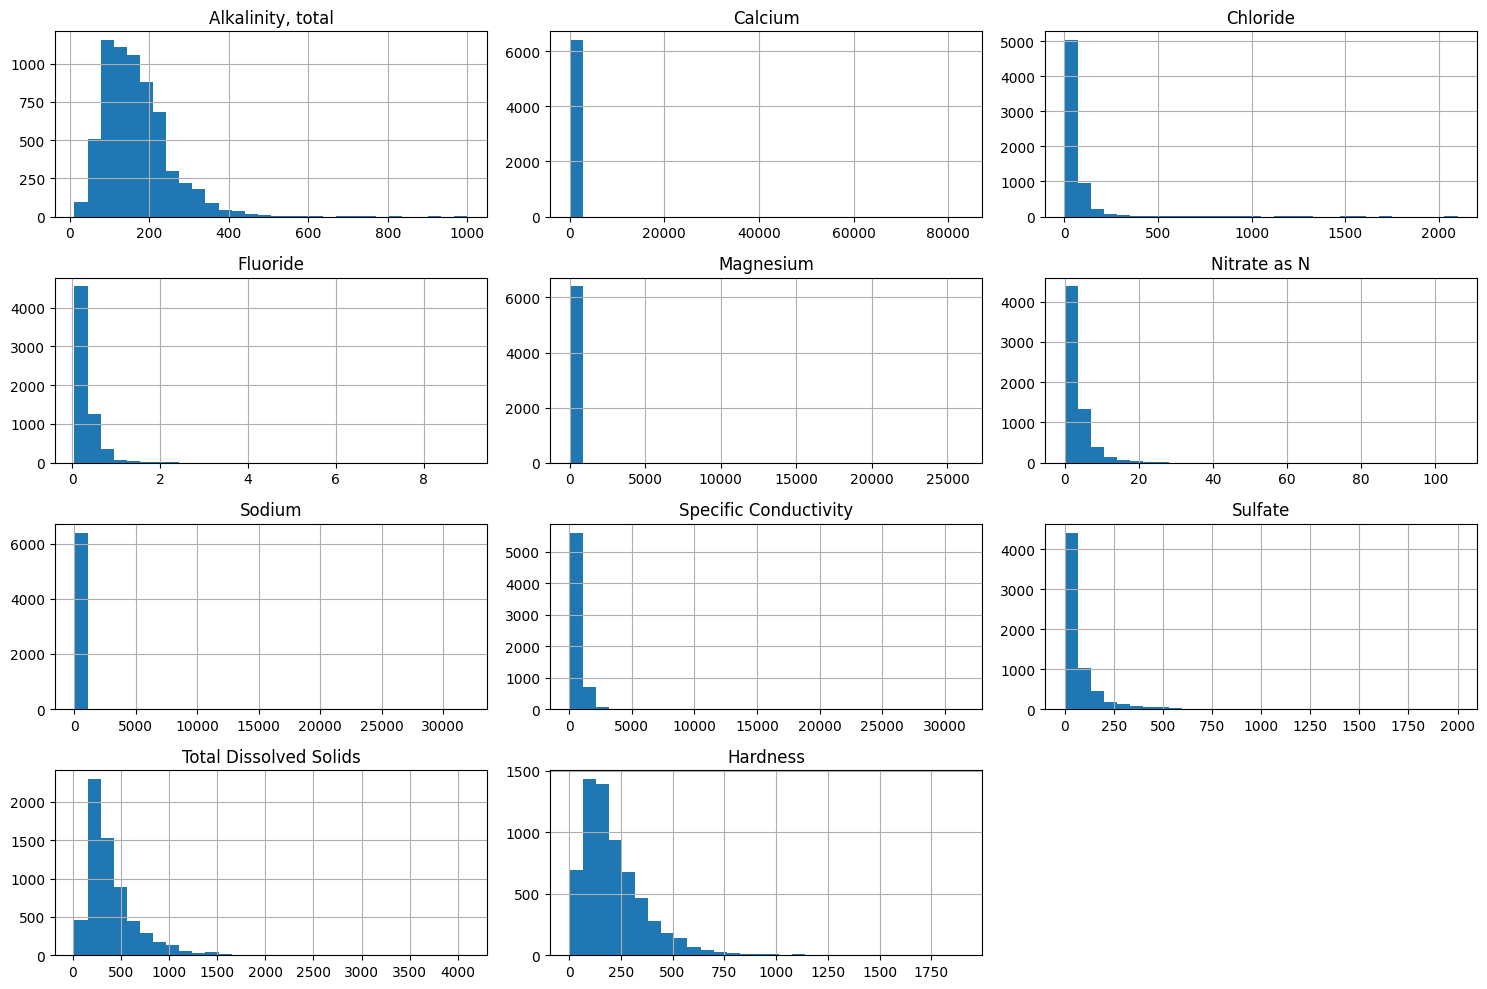

In [ ]:
# Visualisasi distribusi fitur
plt.figure(figsize=(15, 10))
df_train.drop(['id'], axis=1).hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

<ipython-input-23-ca2859a64dd4>:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


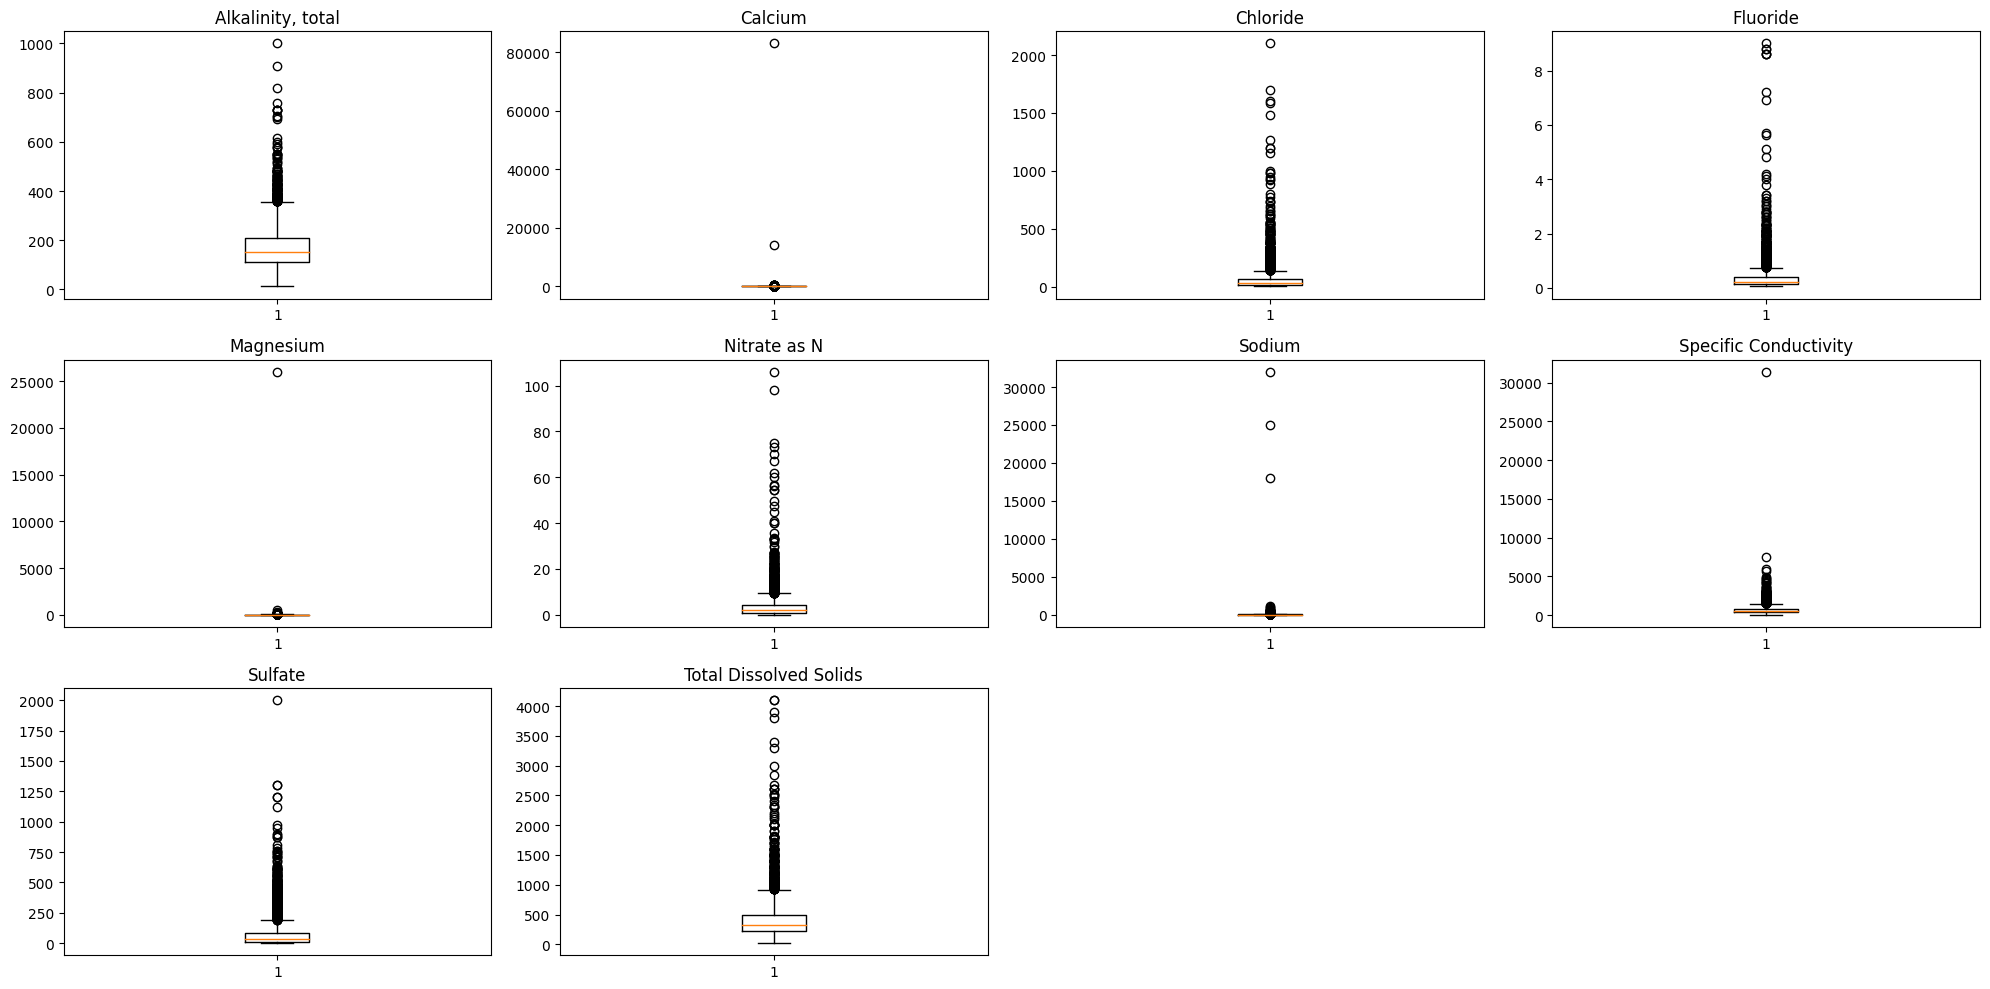

In [ ]:
# Menentukan jumlah kolom dan baris untuk subplot
num_features = df_train.drop(['id','Hardness'], axis=1).shape[1]
num_cols = 4  # Misalnya kita ingin 4 kolom per baris
num_rows = (num_features + num_cols - 1) // num_cols  # Menghitung jumlah baris yang dibutuhkan

# Membuat figure dan axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10), constrained_layout=True)

# Plot setiap fitur pada subplot
for i, column in enumerate(df_train.drop(['id','Hardness'], axis=1).columns):
    ax = axes[i // num_cols, i % num_cols]  # Menentukan posisi subplot
    ax.boxplot(df_train[column])
    ax.set_title(column)

# Menghapus subplot yang kosong
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes.flatten()[j])

# Mengatur layout yang ketat
plt.tight_layout()
plt.show()

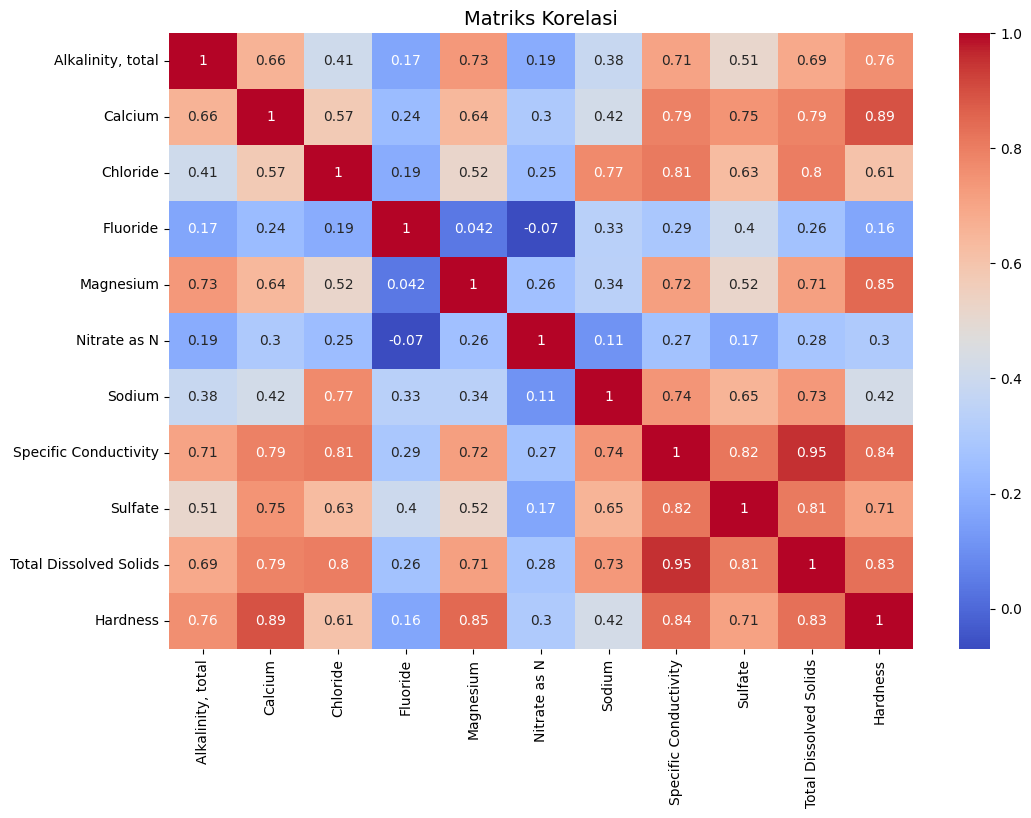

In [ ]:
# Matriks korelasi menggunakan metode Spearman
correlation_matrix = df_train.drop(['id'], axis=1).corr(method='spearman')
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriks Korelasi', fontsize=14)
plt.show()

# Pemodelan

Berdasarkan publikasi World Health Organization (WHO) pada 2009, Magnesium dan Kalsium merupakan mineral utama yang kandungannya mempengaruhi kesadahan air (Hardness). Hal ini juga dibuktikan pada nilai matriks korelasi (dengan metode Spearman), yang menunjukkan korelasi antara Magnesium & Hardness, yaitu 0.85 dan Kalsium & Hardness, yaitu 0.89. Oleh karena itu, dapat disimpulkan bahwa Magnesium & Kalsium berkorelasi kuat dengan Hardness.

Selanjutnya, dibuat sebuah fitur baru yang merupakan selisih dari Magnesium & Kalsium untuk melihat interaksi antara kedua fitur dan akan memberikan *insight* lebih dalam terhadap pemodelan ini.


In [ ]:
df_train['Ca_Mg_abs_diff'] = abs(df_train['Calcium'] - df_train['Magnesium'])
df_test['Ca_Mg_abs_diff'] = abs(df_test['Calcium'] - df_test['Magnesium'])

In [ ]:
X_train = df_train.drop(columns=["Hardness"])
y_train = df_train[["Hardness"]]

In [ ]:
X_train

,id,"Alkalinity, total",Calcium,Chloride,Fluoride,Magnesium,Nitrate as N,Sodium,Specific Conductivity,Sulfate,Total Dissolved Solids,Ca_Mg_abs_diff
0,0,120.0,24.0,6.9,0.314,7.1,0.498,48.0,510.0,23.20,240.0,16.9
1,1,140.0,41.0,11.0,0.150,6.5,0.950,19.0,300.0,8.50,190.0,34.5
2,2,160.0,51.0,9.0,0.450,9.1,2.500,12.0,370.0,25.00,230.0,41.9
3,3,46.0,13.0,2.9,0.120,2.7,0.430,6.4,110.0,5.00,97.0,10.3
4,4,240.0,147.0,70.0,0.600,48.0,6.800,93.0,1410.0,418.00,950.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6395,6395,180.0,58.0,40.0,0.180,25.0,3.600,22.0,540.0,48.00,400.0,33.0
6396,6396,44.0,5.7,3.0,0.120,3.7,0.470,5.9,100.0,0.85,56.0,2.0
6397,6397,138.0,40.3,28.4,0.100,14.2,8.600,31.0,438.0,17.70,300.0,26.1
6398,6398,210.0,110.0,190.0,0.230,47.0,7.900,120.0,1400.0,140.00,800.0,63.0


In [ ]:
y_train

,Hardness
0,90.4
1,130.0
2,160.0
3,41.0
4,586.0
...,...
6395,219.0
6396,30.0
6397,159.0
6398,470.0


In [ ]:
X_test = df_test
X_test

,id,"Alkalinity, total",Calcium,Chloride,Fluoride,Magnesium,Nitrate as N,Sodium,Specific Conductivity,Sulfate,Total Dissolved Solids,Ca_Mg_abs_diff
0,6400,93.0,15.9,3.6,0.100,11.90,1.400,12.7,208.0,6.5,156.0,4.00
1,6401,180.0,34.0,200.0,1.900,8.20,1.300,300.0,1700.0,210.0,860.0,25.80
2,6402,95.0,44.0,35.0,0.081,3.30,1.100,28.0,390.0,22.0,240.0,40.70
3,6403,110.0,29.0,12.0,0.250,6.00,0.150,23.0,283.0,15.0,190.0,23.00
4,6404,179.0,59.0,51.7,0.160,45.00,4.100,64.0,976.0,170.0,430.0,14.00
...,...,...,...,...,...,...,...,...,...,...,...,...
1596,7996,88.0,30.0,11.0,0.170,3.20,1.217,24.0,289.0,22.0,140.0,26.80
1597,7997,64.0,21.0,18.0,0.050,0.68,4.700,31.0,327.0,28.0,160.0,20.32
1598,7998,210.0,32.0,53.0,0.150,24.00,0.120,68.0,570.0,25.0,670.0,8.00
1599,7999,230.0,82.0,14.0,0.100,9.00,2.000,19.0,580.0,24.0,310.0,73.00


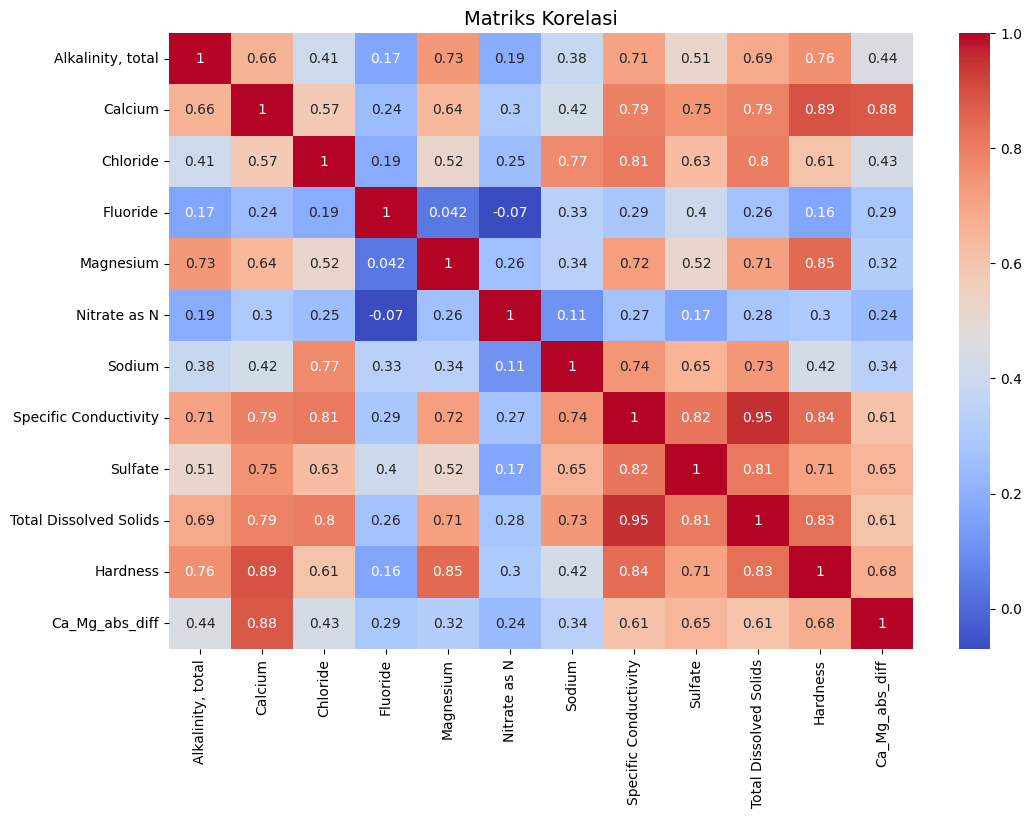

In [ ]:
correlation_matrix = df_train.drop(['id'], axis=1).corr(method='spearman')
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriks Korelasi', fontsize=14)
plt.show()

## Model Artificial Neural Network

In [ ]:
# Normalisasi data dengan Robust
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Set seed untuk random number generation
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Inisialisasi model Sequential
model = Sequential()

# Menambahkan layer input dan hidden layer pertama
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))

# Menambahkan hidden layer kedua
model.add(Dense(64, activation='relu'))

# Menambahkan layer output
model.add(Dense(1))

# Kompilasi model
model.compile(optimizer='adam', loss='mean_squared_error')

# Melatih model pada data training yang telah diskalakan
model.fit(X_train_scaled, y_train, epochs=100, batch_size=10, verbose=0)

# Memprediksi pada data testing yang telah diskalakan
y_pred = model.predict(X_test_scaled)

51/51 [==============================] - 0s 1ms/step


In [ ]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
160/160 [==============================] - 1s 3ms/step - loss: 29932458.0000 - val_loss: 4138234.0000
Epoch 2/100
160/160 [==============================] - 0s 2ms/step - loss: 1873581.3750 - val_loss: 1684910.2500
Epoch 3/100
160/160 [==============================] - 0s 3ms/step - loss: 897872.0000 - val_loss: 946061.3750
Epoch 4/100
160/160 [==============================] - 0s 2ms/step - loss: 621175.2500 - val_loss: 721554.7500
Epoch 5/100
160/160 [==============================] - 0s 2ms/step - loss: 465682.8438 - val_loss: 403733.3750
Epoch 6/100
160/160 [==============================] - 0s 2ms/step - loss: 385747.2500 - val_loss: 350408.4375
Epoch 7/100
160/160 [==============================] - 0s 3ms/step - loss: 320891.9375 - val_loss: 269549.8750
Epoch 8/100
160/160 [==============================] - 0s 2ms/step - loss: 276003.9375 - val_loss: 208081.4062
Epoch 9/100
160/160 [==============================] - 0s 2ms/step - loss: 247512.8750 - val_loss: 237207.2

In [ ]:
pd.DataFrame(history.history).to_csv("./keras_sequential_history.csv", index=False)

In [ ]:
history_df = pd.read_csv("./keras_sequential_history.csv")

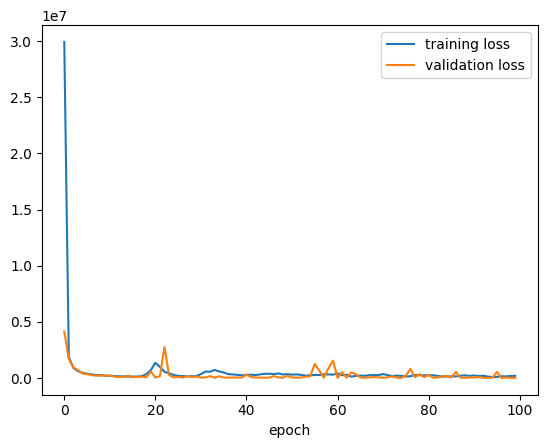

In [ ]:
plt.plot(history_df["loss"], label = "training loss")
plt.plot(history_df["val_loss"], label = "validation loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
df_y_pred = pd.DataFrame(y_pred, columns=['Hardness'])
df_y_pred

,Hardness
0,86.731514
1,83.490875
2,115.337265
3,93.492661
4,318.661133
...,...
1596,81.933983
1597,60.170055
1598,189.138351
1599,230.309814


In [ ]:
X_test_id= X_test['id']
X_test_id

0       6400
1       6401
2       6402
3       6403
4       6404
        ... 
1596    7996
1597    7997
1598    7998
1599    7999
1600    8000
Name: id, Length: 1601, dtype: int64

In [ ]:
hardness_with_id = pd.concat([X_test_id, df_y_pred], axis=1)
print(hardness_with_id)

        id    Hardness
0     6400   86.731514
1     6401   83.490875
2     6402  115.337265
3     6403   93.492661
4     6404  318.661133
...    ...         ...
1596  7996   81.933983
1597  7997   60.170055
1598  7998  189.138351
1599  7999  230.309814
1600  8000  181.859329

[1601 rows x 2 columns]


In [ ]:
hardness_with_id = pd.concat([X_test_id, df_y_pred], axis=1)
hardness_with_id_df = pd.DataFrame(hardness_with_id)
hardness_with_id_df

,id,Hardness
0,6400,86.731514
1,6401,83.490875
2,6402,115.337265
3,6403,93.492661
4,6404,318.661133
...,...,...
1596,7996,81.933983
1597,7997,60.170055
1598,7998,189.138351
1599,7999,230.309814


In [ ]:
hardness_with_id_df.to_csv("FIX_ANN_TheSleepyhead.csv", index = False)